In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eval-dataset-dids/correct_predictions_per (1).csv
/kaggle/input/eval-dataset-dids/skepticism_index_role0.csv
/kaggle/input/eval-dataset-dids/correct_predictions_per (3).csv
/kaggle/input/eval-dataset-dids/skepticism_index_role2.csv
/kaggle/input/eval-dataset-dids/skepticism_index_role3.csv
/kaggle/input/eval-dataset-dids/skepticism_index_role4.csv
/kaggle/input/eval-dataset-dids/skepticism_index_role1.csv
/kaggle/input/temp-data/correct_predictions_per_for_17.5k.csv
/kaggle/input/temp-data/testing_queries_for_15k.csv
/kaggle/input/temp-data/skepticism_index_role4_for_5k.csv
/kaggle/input/temp-data/skepticism_index_role0_for_5k.csv
/kaggle/input/temp-data/training_queries_for_20k.csv
/kaggle/input/temp-data/training_queries_for_15k.csv
/kaggle/input/temp-data/skepticism_index_role2_for_22.5k.csv
/kaggle/input/temp-data/training_queries_for_17.5k.csv
/kaggle/input/temp-data/skepticism_index_role3_for_5k.csv
/kaggle/input/temp-data/skepticism_index_role2_for_20k.csv
/kaggle/

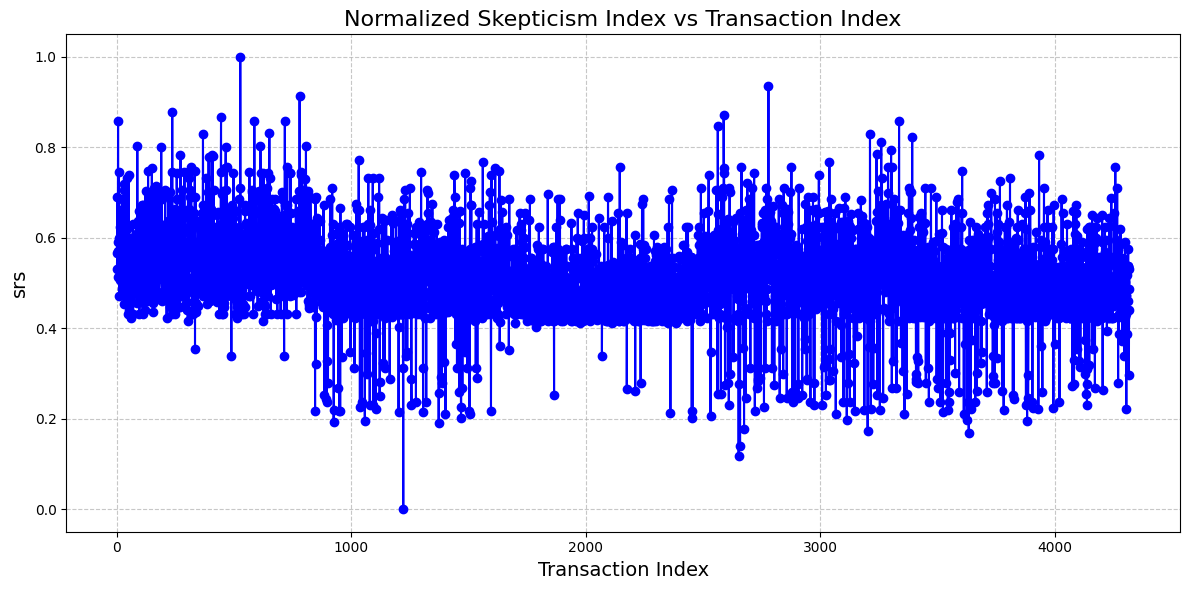

In [2]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# Update these paths to the correct location of your files
transaction_files = [
    '/kaggle/input/temp-data/skepticism_index_role0_for_22.5k.csv',
    '/kaggle/input/temp-data/skepticism_index_role1_for_22.5k.csv',
    '/kaggle/input/temp-data/skepticism_index_role2_for_22.5k.csv',
    '/kaggle/input/temp-data/skepticism_index_role3_for_22.5k.csv',
    '/kaggle/input/temp-data/skepticism_index_role4_for_22.5k.csv'
]

# Combine all transaction data
transactions_combined = pd.concat(
    [pd.read_csv(f) for f in transaction_files],
    ignore_index=True
)

# Process combined transactions
transactions_combined['transaction'] = transactions_combined['transaction'].apply(ast.literal_eval)
transactions_combined['srs'] = transactions_combined['srs'].astype(float)

# Plot normalized_skepticism_index against transaction index
plt.figure(figsize=(12, 6))
plt.plot(transactions_combined.index, transactions_combined['srs'], 
         marker='o', linestyle='-', color='b')
plt.title('Normalized Skepticism Index vs Transaction Index', fontsize=16)
plt.xlabel('Transaction Index', fontsize=14)
plt.ylabel('srs', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('srs_vs_transaction_index.png')
plt.show()

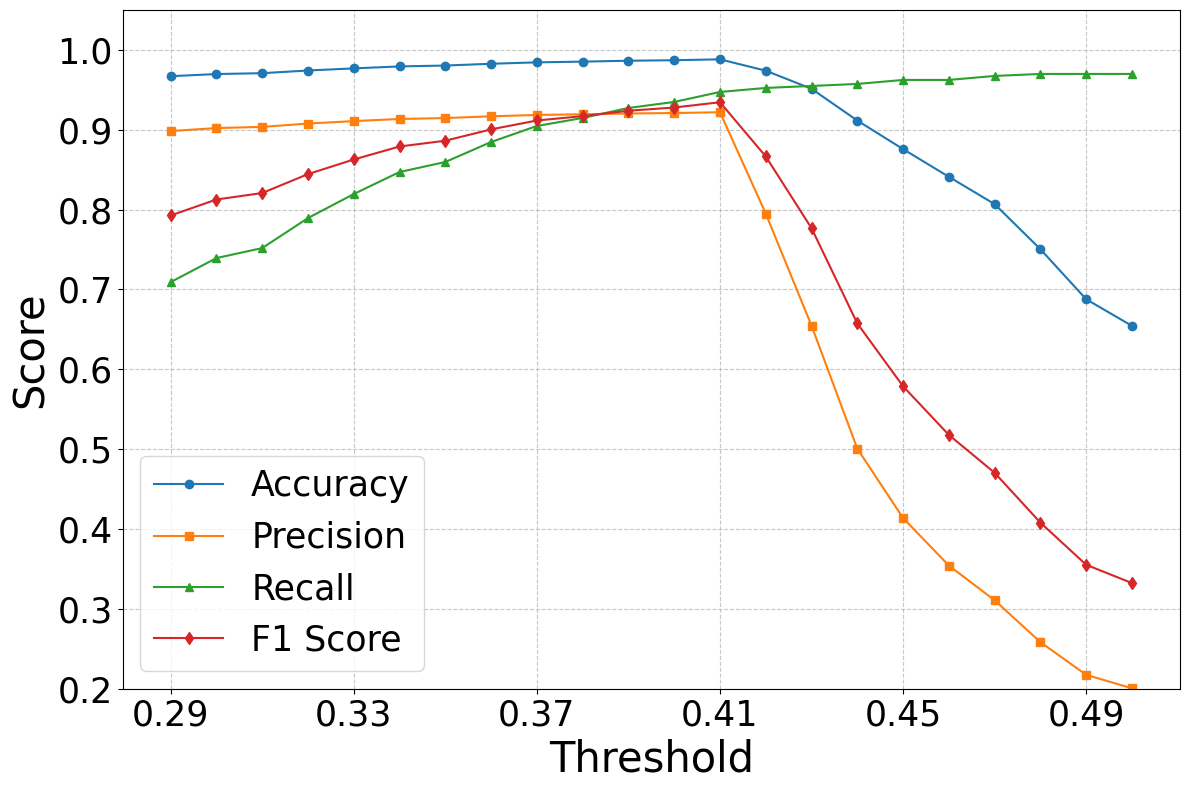

In [41]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load all transaction datasets
transaction_files = [
    '/kaggle/input/eval-dataset-dids/skepticism_index_role0.csv',
    '/kaggle/input/eval-dataset-dids/skepticism_index_role1.csv', 
    '/kaggle/input/eval-dataset-dids/skepticism_index_role2.csv',
    '/kaggle/input/eval-dataset-dids/skepticism_index_role3.csv',
    '/kaggle/input/eval-dataset-dids/skepticism_index_role4.csv'
]

# Combine all transaction data
transactions_combined = pd.concat(
    [pd.read_csv(f) for f in transaction_files],
    ignore_index=True
)

# Process combined transactions
transactions_combined['transaction'] = transactions_combined['transaction'].apply(ast.literal_eval)
transactions_combined['srs'] = transactions_combined['srs'].astype(float)

# Handle duplicate transactions (keep last occurrence)
transactions_combined = transactions_combined.drop_duplicates(
    subset='transaction',
    keep='last'
)

# Create unified transaction database
transaction_db = {
    tuple(row['transaction']): row['srs']
    for _, row in transactions_combined.iterrows()
}

# Load query dataset
queries_df = pd.read_csv('/kaggle/input/temp-data/correct_predictions_per_for_22.5k.csv')
queries_df['query'] = queries_df['query'].apply(ast.literal_eval)

# Define thresholds to evaluate
thresholds = [0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5]

# Initialize results dictionary
metrics = {
    'Threshold': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Function to classify a query based on threshold
def classify_query(query, threshold):
    query_tuple = tuple(query)
    if query_tuple in transaction_db:
        score = transaction_db[query_tuple]
        return 0 if score > threshold else 1
    return pd.NA

# Evaluate metrics for each threshold
for threshold in thresholds:
    # Apply classification with current threshold
    queries_df['pred_by_rules'] = queries_df['query'].apply(lambda q: classify_query(q, threshold))
    
    # Create final_pred column (1 if either column is 1, else 0)
    # This combines the original predicted_class with the rules-based prediction
    queries_df['final_pred'] = queries_df[['predicted_class', 'pred_by_rules']].max(axis=1)
    
    # Handle missing values
    valid_df = queries_df.dropna(subset=['class', 'final_pred'])
    
    # Convert to integers
    y_true = valid_df['class'].astype(int)
    y_pred = valid_df['final_pred'].astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Store metrics
    metrics['Threshold'].append(threshold)
    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1 Score'].append(f1)

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Plot the metrics with adjusted y-axis range
plt.figure(figsize=(12, 8))

plt.plot(metrics_df['Threshold'], metrics_df['Accuracy'], marker='o', label='Accuracy')
plt.plot(metrics_df['Threshold'], metrics_df['Precision'], marker='s', label='Precision')
plt.plot(metrics_df['Threshold'], metrics_df['Recall'], marker='^', label='Recall')
plt.plot(metrics_df['Threshold'], metrics_df['F1 Score'], marker='d', label='F1 Score')

# plt.title('Performance Metrics at Different Thresholds', fontsize=16)
plt.xlabel('Threshold', fontsize=30)
plt.ylabel('Score', fontsize=30)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=25)
plt.xticks(thresholds[::4], fontsize=25)  # Show every other threshold to avoid crowding
# plt.xticks(thresholds) 
plt.yticks(fontsize=25)
plt.ylim(0.2, 1.05)  # Modified to focus on 0.8 to 1.05 range

# Add value labels on the plot (with reduced frequency for readability)
# for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
#     for i, value in enumerate(metrics_df[metric]):
#         if i % 2 == 0:  # Only label every other point to reduce crowding
#             plt.text(metrics_df['Threshold'][i], value + 0.01, 
#                     f'{value:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('metrics_vs_thresholds_focused.png')
plt.show()

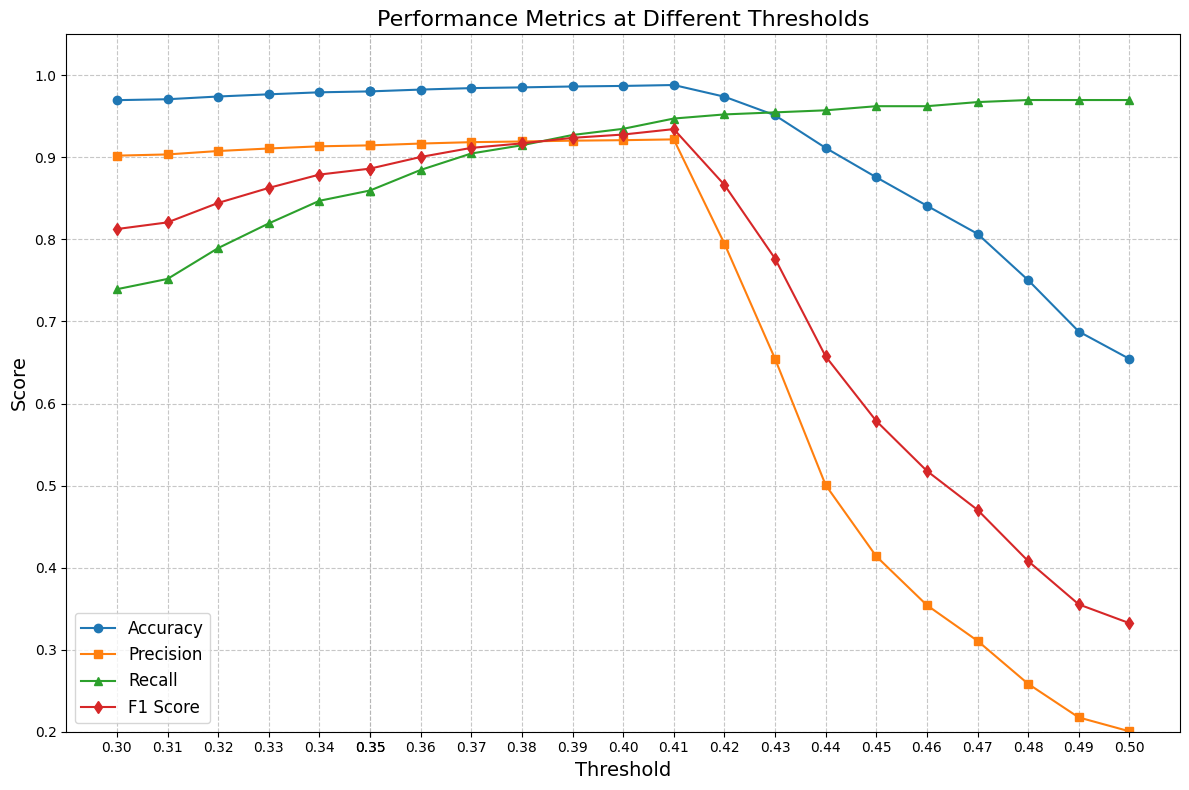

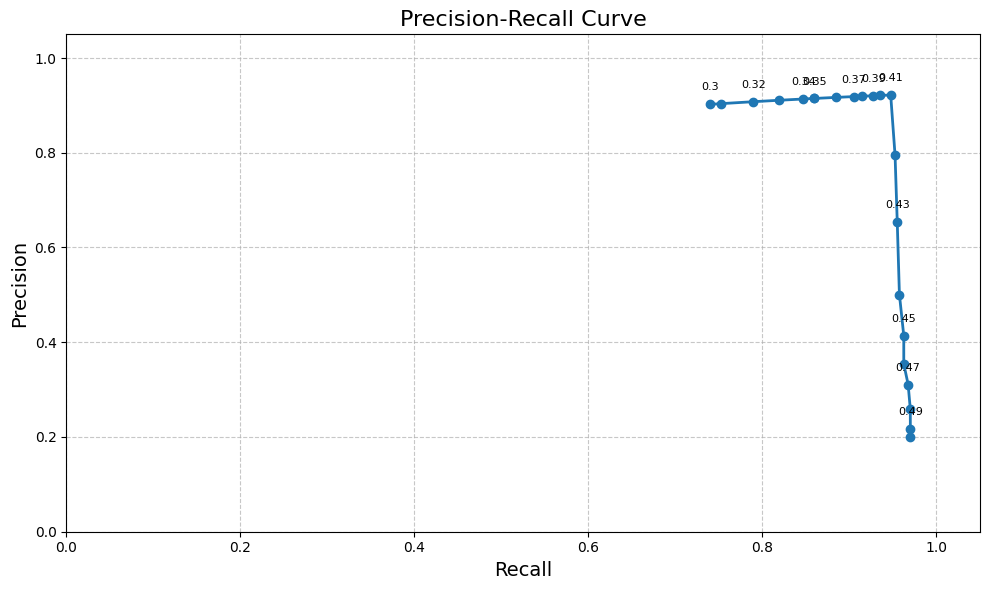

In [ ]:
# Create a second plot for precision-recall curve with adjusted axis
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Recall'], metrics_df['Precision'], marker='o', linestyle='-', linewidth=2)

# Add threshold annotations (with reduced frequency)
for i, threshold in enumerate(metrics_df['Threshold']):
    if i % 2 == 0:  # Only label every other point
        plt.annotate(f'{threshold}', 
                    (metrics_df['Recall'][i], metrics_df['Precision'][i]),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center',
                    fontsize=8)

plt.title('Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 1.05)  # Modified to focus on 0.8 to 1.05 range
plt.ylim(0, 1.05)  # Modified to focus on 0.8 to 1.05 range
plt.tight_layout()
plt.savefig('precision_recall_curve_focused.png')
plt.show()

Threshold: 0.41
Accuracy:  0.9902
Precision: 0.9236
Recall:    0.9699
F1 Score:  0.9462
Confusion Matrix:
[[4069   32]
 [  12  387]]


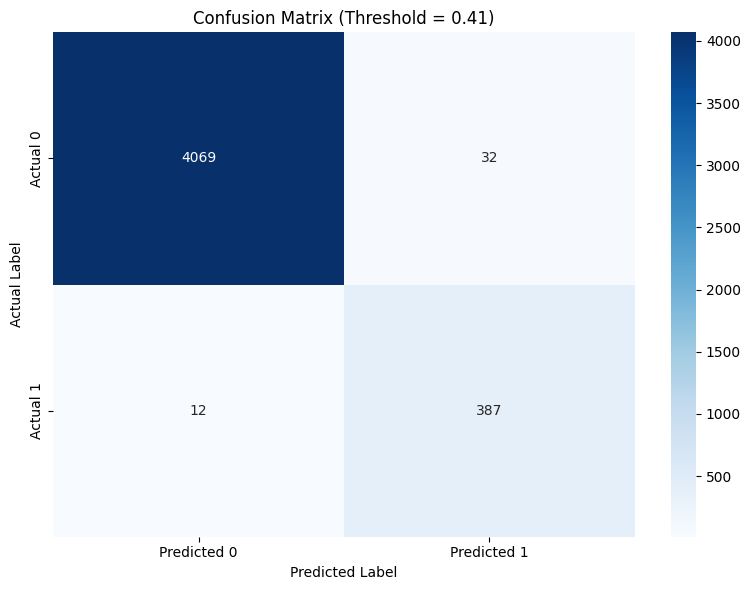

In [4]:
import pandas as pd
import ast
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load all transaction datasets
transaction_files = [
    '/kaggle/input/temp-data/skepticism_index_role0_for_22.5k.csv',
    '/kaggle/input/temp-data/skepticism_index_role1_for_22.5k.csv', 
    '/kaggle/input/temp-data/skepticism_index_role2_for_22.5k.csv',
    '/kaggle/input/temp-data/skepticism_index_role3_for_22.5k.csv',
    '/kaggle/input/temp-data/skepticism_index_role4_for_22.5k.csv'
]

# Combine all transaction data
transactions_combined = pd.concat(
    [pd.read_csv(f) for f in transaction_files],
    ignore_index=True
)

# Process combined transactions
transactions_combined['transaction'] = transactions_combined['transaction'].apply(ast.literal_eval)
transactions_combined['srs'] = transactions_combined['srs'].astype(float)

# Handle duplicate transactions (keep last occurrence)
transactions_combined = transactions_combined.drop_duplicates(
    subset='transaction',
    keep='last'
)

# Create unified transaction database
transaction_db = {
    tuple(row['transaction']): row['srs']
    for _, row in transactions_combined.iterrows()
}

# Load query dataset
queries_df = pd.read_csv('/kaggle/input/temp-data/correct_predictions_per_for_22.5k.csv')
queries_df['query'] = queries_df['query'].apply(ast.literal_eval)

# Function to classify a query based on threshold
def classify_query(query, threshold):
    query_tuple = tuple(query)
    if query_tuple in transaction_db:
        score = transaction_db[query_tuple]
        return 0 if score > threshold else 1
    return pd.NA

# Apply classification with threshold = 0.41
threshold = 0.41
queries_df['pred_by_rules'] = queries_df['query'].apply(lambda q: classify_query(q, threshold))

# Create final_pred column (1 if either column is 1, else 0)
queries_df['final_pred'] = queries_df[['predicted_class', 'pred_by_rules']].max(axis=1)

# Handle missing values
valid_df = queries_df.dropna(subset=['class', 'final_pred'])

# Convert to integers
y_true = valid_df['class'].astype(int)
y_pred = valid_df['final_pred'].astype(int)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
conf_matrix = confusion_matrix(y_true, y_pred)

# Print metrics
print(f"Threshold: {threshold}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()